# Methods Notebook: Extracting Call Samples for KMeans Clustering

## Imports Section:

In [1]:
import numpy as np
import pandas as pd
import random
import scipy
from scipy import stats
import datetime as dt
import dask.dataframe as dd

In [2]:
import librosa
import warnings

In [3]:
import glob
import matplotlib.pyplot as plt
from matplotlib import colors
import soundfile as sf
import matplotlib.patches as patches
from pathlib import Path

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

In [5]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
import src.file_dealer as file_dealer
from bat_detect.detector import models
from cfg import get_config
from pipeline import pipeline
from utils.utils import gen_empty_df, convert_df_ravenpro
from bat_detect.utils import wavfile
import bat_detect.utils.detector_utils as du
import bat_detect.detector.compute_features as feats
import bat_detect.detector.post_process as pp

## Function Definitions (most important functions are in `src/`)
### Below are the functions used for plotting and visualization

In [6]:
def plot_audio_seg(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()


def plot_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(spec_features['plot_title'], fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax)

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=1, edgecolor='yellow', facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.ylabel("Frequency (kHz)")
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.xlabel("Time (s)")
    plt.twinx(ax=ax)
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plt.ylabel("Frequency (kHz)")

    plt.show()

In [7]:
def convert_nabatdf_to_ravenprodf(df):
    raven_df = pd.DataFrame()
    raven_df['Begin Time (s)'] =  (df['peak_time_ms']-50)/1000
    raven_df['End Time (s)'] = (df['peak_time_ms']-40)/1000
    raven_df['Low Freq (Hz)'] = df['peak_freq_hz']-2000
    raven_df['High Freq (Hz)'] = df['peak_freq_hz']+2000
    raven_df['prediction'] = df['prediction']
    raven_df['score'] = df['score']
    raven_df.sort_values('Begin Time (s)', inplace=True)
    raven_df.insert(0, 'Selection', np.arange(len(raven_df)).astype(int)+1)

    raventxt_df = pd.DataFrame(np.repeat(raven_df.values, 2, axis=0))
    raventxt_df.columns = raven_df.columns
    raventxt_df['Selection'] = raventxt_df['Selection'].astype(int)
    raventxt_df.insert(1, 'Channel', [1]*raventxt_df.shape[0])
    views = np.array(['Waveform 1']*raventxt_df.shape[0], dtype='object')
    views[1::2] = 'Spectrogram 1'
    raventxt_df.insert(1, 'View', views)

    return raventxt_df

def convert_nabatdf_to_bd2df(df):
    bd2_df = pd.DataFrame()
    bd2_df['start_time'] = (df['peak_time_ms']-50)/1000
    bd2_df['end_time'] = (df['peak_time_ms']-40)/1000
    bd2_df['low_freq'] = df['peak_freq_hz']-2000
    bd2_df['high_freq'] = df['peak_freq_hz']+2000
    bd2_df['prediction'] = df['prediction']
    bd2_df['score'] = df['score']
    bd2_df.sort_values('start_time', inplace=True)
    
    return bd2_df

def convert_kaleidoscopedf_to_ravenprodf(df):
    raven_df = pd.DataFrame()
    raven_df['Begin Time (s)'] = df['OFFSET']
    raven_df['End Time (s)'] = df['OFFSET'] + df['DURATION']
    raven_df['Low Freq (Hz)'] = df['Fmin']
    raven_df['High Freq (Hz)'] = df['Fmax']
    raven_df['input_file'] = df['IN FILE']
    raven_df['input_dir'] = df['INDIR']
    raven_df['mean_freq'] = df['Fmean']
    if 'TOP1MATCH*' in df.columns:
        raven_df['TOP1MATCH*'] = df['TOP1MATCH*']
    if 'TOP1MATCH' in df.columns:
        raven_df['TOP1MATCH'] = df['TOP1MATCH']
    raven_df['TOP1DIST'] = df['TOP1DIST']
    raven_df['TOP2MATCH'] = df['TOP2MATCH']
    raven_df['TOP2DIST'] = df['TOP2DIST']
    raven_df['TOP3MATCH'] = df['TOP3MATCH']
    raven_df['TOP3DIST'] = df['TOP3DIST']
    raven_df.sort_values('Begin Time (s)', inplace=True)
    raven_df.insert(0, 'Selection', np.arange(len(raven_df)).astype(int)+1)

    raventxt_df = pd.DataFrame(np.repeat(raven_df.values, 2, axis=0))
    raventxt_df.columns = raven_df.columns
    raventxt_df['Selection'] = raventxt_df['Selection'].astype(int)
    raventxt_df.insert(1, 'Channel', [1]*raventxt_df.shape[0])
    views = np.array(['Waveform 1']*raventxt_df.shape[0], dtype='object')
    views[1::2] = 'Spectrogram 1'
    raventxt_df.insert(1, 'View', views)

    return raventxt_df

def convert_kaleidoscopedf_to_bd2df(df):
    bd2_df = pd.DataFrame()
    bd2_df['start_time'] = df['OFFSET']
    bd2_df['end_time'] = df['OFFSET'] + df['DURATION']
    bd2_df['low_freq'] = df['Fmin']
    bd2_df['high_freq'] = df['Fmax']
    bd2_df['input_file'] = df['IN FILE']
    bd2_df['input_dir'] = df['INDIR']
    bd2_df['mean_freq'] = df['Fmean']
    if 'TOP1MATCH*' in df.columns:
        bd2_df['TOP1MATCH*'] = df['TOP1MATCH*']
    if 'TOP1MATCH' in df.columns:
        bd2_df['TOP1MATCH'] = df['TOP1MATCH']
    bd2_df['TOP1DIST'] = df['TOP1DIST']
    bd2_df['TOP2MATCH'] = df['TOP2MATCH']
    bd2_df['TOP2DIST'] = df['TOP2DIST']
    bd2_df['TOP3MATCH'] = df['TOP3MATCH']
    bd2_df['TOP3DIST'] = df['TOP3DIST']
    bd2_df.sort_values('start_time', inplace=True)
    
    return bd2_df

def convert_raventxtdf_to_bd2df(raventxt_df):
    bd2_human_df = raventxt_df[::2].copy()
    bd2_human_df = bd2_human_df.drop(columns=['Selection', 'View', 'Channel'])
    bd2_human_df.rename(columns={'Begin Time (s)':'start_time',
                                'End Time (s)':'end_time',
                                'Low Freq (Hz)':'low_freq',
                                'High Freq (Hz)':'high_freq'}, inplace=True)
    bd2_human_df.sort_values('start_time', inplace=True)
    
    return bd2_human_df

In [8]:
wav_filename = '20220730_053000'
site = 'Carp'
plot_file = Path(f'../../Documents/{wav_filename}/input/{wav_filename}.WAV')

In [9]:
kaleido_df = pd.read_csv(f'../../Documents/{wav_filename}/output/cluster.csv')
bd2_kaleido_df = convert_kaleidoscopedf_to_bd2df(kaleido_df)
bd2_kaleido_df

,start_time,end_time,low_freq,high_freq,input_file,input_dir,mean_freq,TOP1MATCH*,TOP1DIST,TOP2MATCH,TOP2DIST,TOP3MATCH,TOP3DIST
0,237.868988,237.870192,26232.047,26756.152,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,26570.713,nocluster,0,NaN,0,NaN,0
1,240.643295,240.645054,24393.871,25565.629,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,25014.352,nocluster,0,NaN,0,NaN,0
2,241.093491,241.094995,26316.930,26845.637,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,26595.945,nocluster,0,NaN,0,NaN,0
3,241.382507,241.384868,26758.547,27789.840,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,27106.775,nocluster,0,NaN,0,NaN,0
4,242.100616,242.102914,23955.531,24692.299,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,24369.277,nocluster,0,NaN,0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,1502.350220,1502.351309,39230.770,41913.539,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,40405.629,nocluster,0,NaN,0,NaN,0
78,1535.820435,1535.825683,17937.580,18563.982,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,18292.221,nocluster,0,NaN,0,NaN,0
79,1536.211670,1536.215410,20408.164,23404.619,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,21388.648,nocluster,0,NaN,0,NaN,0
80,1536.636719,1536.639794,21622.254,23392.613,20220730_053000.WAV,/Users/adityakrishna/Documents/20220730_053000...,22115.746,nocluster,0,NaN,0,NaN,0


In [10]:
nabat_df = pd.read_csv(f'../../nabat-ml-master/classify/nb__{wav_filename}.csv', index_col=0)
bd2_nabat_df = convert_nabatdf_to_bd2df(nabat_df)
bd2_nabat_df

,start_time,end_time,low_freq,high_freq,prediction,score
0,233.31025,233.32025,25000.0,29000.0,LANO,0.620016
1,233.48075,233.49075,25000.0,29000.0,LANO,0.611426
2,235.43300,235.44300,23000.0,27000.0,LANO,0.624760
3,236.85775,236.86775,24000.0,28000.0,LANO,0.426647
4,237.55375,237.56375,24000.0,28000.0,LANO,0.592067
...,...,...,...,...,...,...
214,1503.31675,1503.32675,38000.0,42000.0,MYLU,0.701952
215,1536.21400,1536.22400,19000.0,23000.0,LACI,0.864690
216,1536.63850,1536.64850,20000.0,24000.0,LACI,0.807034
217,1537.06175,1537.07175,20000.0,24000.0,LACI,0.780501


In [11]:
def load_audio_file(audio_file, time_exp_fact, target_samp_rate, scale=False, max_duration=False):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=wavfile.WavFileWarning)
        #sampling_rate, audio_raw = wavfile.read(audio_file)
        audio_raw, sampling_rate = librosa.load(audio_file, sr=None)

    if len(audio_raw.shape) > 1:
        raise Exception('Currently does not handle stereo files')
    sampling_rate = sampling_rate * time_exp_fact

    # resample - need to do this after correcting for time expansion
    sampling_rate_old = sampling_rate
    sampling_rate = target_samp_rate
    audio_raw = librosa.resample(audio_raw, orig_sr=sampling_rate_old, target_sr=sampling_rate, res_type='polyphase')

    # clipping maximum duration
    if max_duration is not False:
        max_duration = np.minimum(int(sampling_rate*max_duration), audio_raw.shape[0])
        audio_raw = audio_raw[:max_duration]
        
    # convert to float32 and scale
    audio_raw = audio_raw.astype(np.float32)
    if scale:
        audio_raw = audio_raw - audio_raw.mean()
        audio_raw = audio_raw / (np.abs(audio_raw).max() + 10e-6)

    return sampling_rate, audio_raw

In [12]:
def run_detector_on_audio_data(model, args, params, audio_full, plot_file, sampling_rate):
    # store temporary results here
    predictions = []
    spec_feats  = []
    cnn_feats   = []
    spec_slices = []

    # get time expansion  factor
    time_exp = args['time_expansion_factor']

    params['detection_threshold'] = args['detection_threshold']
    top_n=5
    # clipping maximum duration
    duration_full = audio_full.shape[0] / float(sampling_rate)

    return_np_spec = args['spec_features'] or args['spec_slices']

    # loop through larger file and split into chunks
    # TODO fix so that it overlaps correctly and takes care of duplicate detections at borders
    num_chunks = int(np.ceil(duration_full/args['chunk_size']))
    for chunk_id in tqdm(range(num_chunks)):
        # chunk
        chunk_time   = args['chunk_size']*chunk_id
        chunk_length = int(sampling_rate*args['chunk_size'])
        start_sample = chunk_id*chunk_length
        end_sample   = np.minimum((chunk_id+1)*chunk_length, audio_full.shape[0])
        audio = audio_full[start_sample:end_sample]

        # load audio file and compute spectrogram
        duration, spec, spec_np = du.compute_spectrogram(audio, sampling_rate, params, return_np_spec)

        # evaluate model
        with torch.no_grad():
            outputs = model(spec, return_feats=args['cnn_features'])

        # run non-max suppression
        pred_nms, features = pp.run_nms(outputs, params, np.array([float(sampling_rate)]))
        pred_nms = pred_nms[0]
        pred_nms['start_times'] += chunk_time
        pred_nms['end_times'] += chunk_time

        # if we have a background class
        if pred_nms['class_probs'].shape[0] > len(params['class_names']):
            pred_nms['class_probs'] = pred_nms['class_probs'][:-1, :]

        predictions.append(pred_nms)

        # extract features - if there are any calls detected
        if (pred_nms['det_probs'].shape[0] > 0):
            if args['spec_features']:
                spec_feats.append(feats.get_feats(spec_np, pred_nms, params))

            if args['cnn_features']:
                cnn_feats.append(features[0])

            if args['spec_slices']:
                spec_slices.extend(feats.extract_spec_slices(spec_np, pred_nms, params))

    # convert the predictions into output dictionary
    file_id = plot_file.name
    predictions, spec_feats, cnn_feats, spec_slices =\
                du.merge_results(predictions, spec_feats, cnn_feats, spec_slices)
    results = du.convert_results(file_id, time_exp, duration_full, params,
                                predictions, spec_feats, cnn_feats, spec_slices)

    # summarize results
    if not args['quiet']:
        num_detections = len(results['pred_dict']['annotation'])
        print('{}'.format(num_detections) + ' call(s) detected above the threshold.')

    # print results for top n classes
    if not args['quiet'] and (num_detections > 0):
        class_overall = pp.overall_class_pred(predictions['det_probs'], predictions['class_probs'])
        print('species name'.ljust(30) + 'probablity present')
        for cc in np.argsort(class_overall)[::-1][:top_n]:
            print(params['class_names'][cc].ljust(30) + str(round(class_overall[cc], 3)))

    annotations = results['pred_dict']['annotation']
    out_df = gen_empty_df()
    if annotations:
        out_df = pd.DataFrame.from_records(annotations) 

    return out_df

In [13]:
resampling_rate, audio_data_resampled = load_audio_file(plot_file, 1, 256000)

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net_params = torch.load('../src/models/bat_call_detector/batdetect2/models/Net2DFast_UK_same.pth.tar', map_location=device)
params = net_params['params']
params['device'] = device
model = models.Net2DFast(params['num_filters'], num_classes=len(params['class_names']),
                            emb_dim=params['emb_dim'], ip_height=params['ip_height'],
                            resize_factor=params['resize_factor'])
model.load_state_dict(net_params['state_dict'])
model = model.to(params['device'])
model.eval()

Net2DFast(
  (conv_dn_0): ConvBlockDownCoordF(
    (conv): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_1): ConvBlockDownCoordF(
    (conv): Conv2d(33, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_2): ConvBlockDownCoordF(
    (conv): Conv2d(65, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv_dn_3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_dn_3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_1d): Conv2d(256, 256, kernel_size=(16, 1), stride=(1, 1))
  (conv_1d_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (a

In [16]:
batdetect2_df = pd.read_csv(f'../../duty-cycle-investigation/data/raw/{site}/bd2__{site}_{wav_filename}.csv', sep=',')
batdetect2_df

,start_time,end_time,low_freq,high_freq,event,class,class_prob,det_prob,individual,input_file,Site name,Recover Folder,SD Card,File Duration
0,231.2775,231.2891,25468.0,30247.0,Echolocation,Nyctalus leisleri,0.359,0.592,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
1,231.6515,231.6635,24609.0,29885.0,Echolocation,Nyctalus leisleri,0.297,0.598,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
2,231.9315,231.9459,24609.0,29998.0,Echolocation,Nyctalus leisleri,0.340,0.545,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
3,232.4015,232.4206,24609.0,29436.0,Echolocation,Nyctalus leisleri,0.309,0.530,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
4,232.7135,232.7302,23750.0,28253.0,Echolocation,Nyctalus leisleri,0.411,0.555,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,1537.3465,1537.3563,20312.0,28303.0,Echolocation,Nyctalus noctula,0.380,0.589,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
340,1537.6905,1537.7014,19453.0,26289.0,Echolocation,Nyctalus noctula,0.438,0.610,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
341,1630.8985,1630.9081,43515.0,49360.0,Echolocation,Pipistrellus pipistrellus,0.317,0.510,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795
342,1636.5625,1636.5707,44375.0,57442.0,Echolocation,Pipistrellus pipistrellus,0.538,0.639,-1,/mnt/ubna_data_01_mir/recover-20220801/UBNA_00...,Carp Pond,recover-20220801,4,1795


In [17]:
raventxt_human_df = pd.read_csv(f'../../Documents/Research/mila_files/mila-human-wav-txt/{wav_filename}.txt', sep='\t')
bd2_human_df = convert_raventxtdf_to_bd2df(raventxt_human_df)
bd2_human_df.reset_index(inplace=True, drop=True)
bd2_human_df

,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event,input_file,Site name,Recover Folder,SD Card,confidency
0,230.973665,230.986303,24402.235,29229.050,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,231.133100,231.150599,24670.391,28156.425,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
2,231.277500,231.289100,25468.000,30247.000,Nyctalus leisleri,0.359,0.592,-1.0,Echolocation,/mnt/ubna_data_01/recover-20220801/UBNA_004/20...,Carp Pond,NaN,NaN,NaN
3,231.651500,231.663500,24609.000,29885.000,Nyctalus leisleri,0.297,0.598,-1.0,Echolocation,/mnt/ubna_data_01/recover-20220801/UBNA_004/20...,Carp Pond,NaN,NaN,NaN
4,231.931500,231.945900,24609.000,29998.000,Nyctalus leisleri,0.340,0.545,-1.0,Echolocation,/mnt/ubna_data_01/recover-20220801/UBNA_004/20...,Carp Pond,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,1636.754878,1636.764600,47195.531,50145.251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
668,1637.438310,1637.462614,42100.559,48804.469,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
669,1637.521916,1637.537470,43173.184,49877.095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
670,1637.608500,1637.615800,44375.000,51902.000,Pipistrellus pipistrellus,0.476,0.513,-1.0,Echolocation,/mnt/ubna_data_01/recover-20220801/UBNA_004/20...,Carp Pond,NaN,NaN,NaN


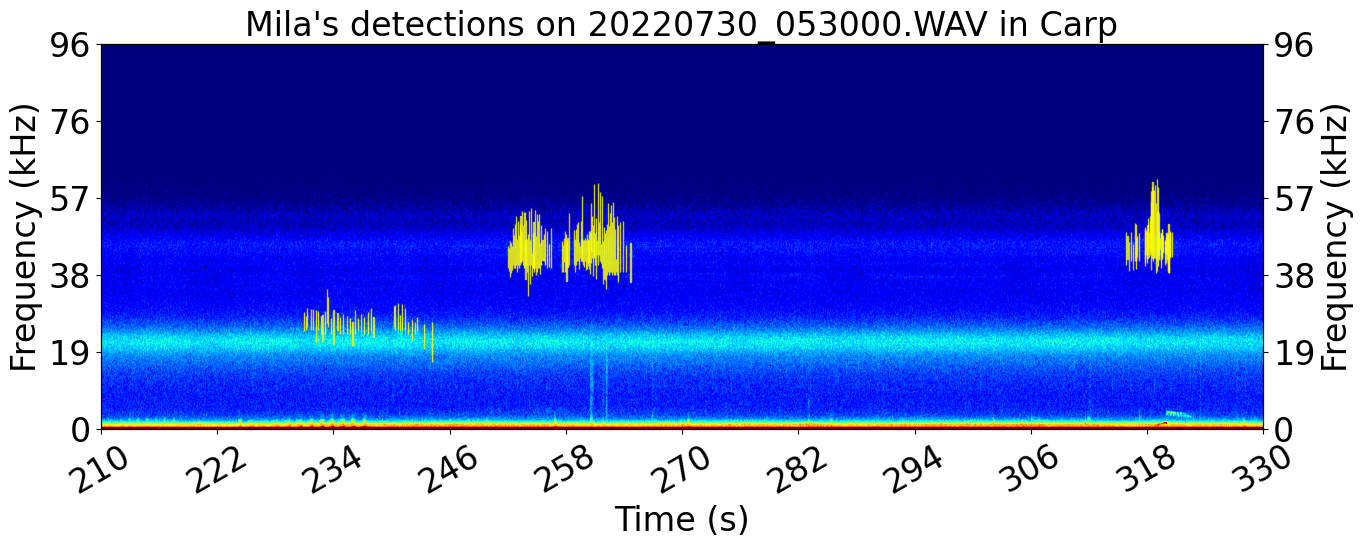

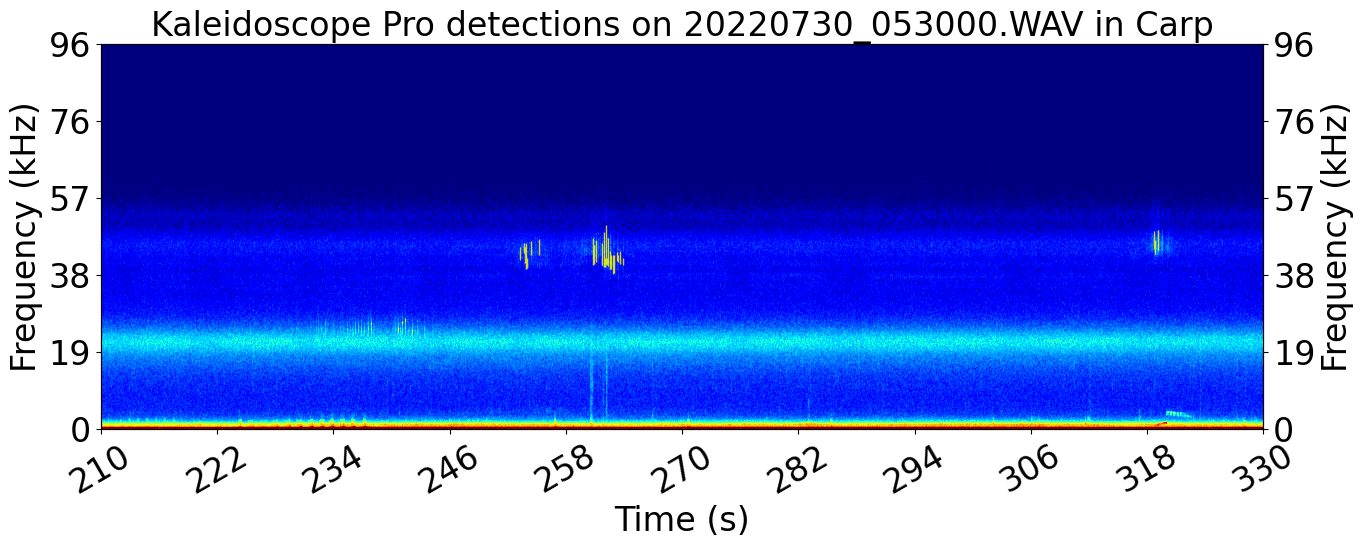

In [18]:
# Below we filter our detections dataframe to only get the detections corresponding to the above audio file
audio_file = sf.SoundFile(plot_file)
fs = audio_file.samplerate
start = 210
duration = 120
audio_file.seek(int(fs*start))
audio_seg = audio_file.read(int(fs*duration))
lower_dB = -40
upper_dB = 0
vmin = 20*np.log10(np.max(audio_seg)) + lower_dB # hide anything below lower_dB dB
vmax = 20*np.log10(np.max(audio_seg)) + upper_dB # hide anything above upper_dB dB
audio_features = dict()
audio_features['file_path'] = Path(plot_file)
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = start
audio_features['duration'] = duration

spec_features = dict()
spec_features['NFFT'] = 1024 # When segments are short, NFFT should also be small to best see calls (must always be > 128)
spec_features['cmap'] = 'jet' # This colormap shows best contrast between noise and signals
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax


spec_features['plot_title'] = f"Human-made detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, bd2_human_df)
spec_features['plot_title'] = f"Kaleidoscope Pro detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, bd2_kaleido_df)

In [19]:
# resamp_audio_seg = audio_data_resampled[int(resampling_rate*start):int(resampling_rate*(start+duration))]
for thresh in np.arange(0, 1, 0.01):
    args = dict()
    args['time_expansion_factor'] = 1.0
    args['detection_threshold'] = thresh
    args['chunk_size'] = 3
    args['spec_slices'] = False
    args['quiet'] = False
    args['spec_features'] = False
    args['cnn_features'] = True
    batdetect2_df_mod = run_detector_on_audio_data(model, args, params, audio_data_resampled, plot_file, resampling_rate)
    batdetect2_df_mod.to_csv(f"bd2__threshold{str(args['detection_threshold']).replace('.','p')}_chunksize{args['chunk_size']}_{plot_file.name.split('.')[0]}.csv")

100%|██████████| 599/599 [06:50<00:00,  1.46it/s]

537 call(s) detected above the threshold.
species name                  probablity present
Pipistrellus nathusii         0.677
Nyctalus leisleri             0.127
Pipistrellus pipistrellus     0.04
Eptesicus serotinus           0.034
Myotis daubentonii            0.028


,start_time,end_time,low_freq,high_freq,class,class_prob,det_prob,individual,event
0,231.2775,231.2893,25468,30077,Nyctalus leisleri,0.388,0.596,-1,Echolocation
1,231.6515,231.6637,24609,29732,Nyctalus leisleri,0.311,0.592,-1,Echolocation
2,231.9315,231.9461,24609,29849,Nyctalus leisleri,0.356,0.538,-1,Echolocation
3,232.2085,232.2282,24609,29337,Nyctalus leisleri,0.293,0.450,-1,Echolocation
4,232.4015,232.4206,24609,29517,Nyctalus leisleri,0.306,0.531,-1,Echolocation
...,...,...,...,...,...,...,...,...,...
532,1636.3156,1636.3280,44375,49521,Pipistrellus pipistrellus,0.392,0.472,-1,Echolocation
533,1636.5625,1636.5706,44375,57644,Pipistrellus pipistrellus,0.514,0.645,-1,Echolocation
534,1636.6486,1636.6572,44375,54213,Pipistrellus pipistrellus,0.384,0.447,-1,Echolocation
535,1637.5225,1637.5341,45234,57126,Pipistrellus pipistrellus,0.348,0.458,-1,Echolocation


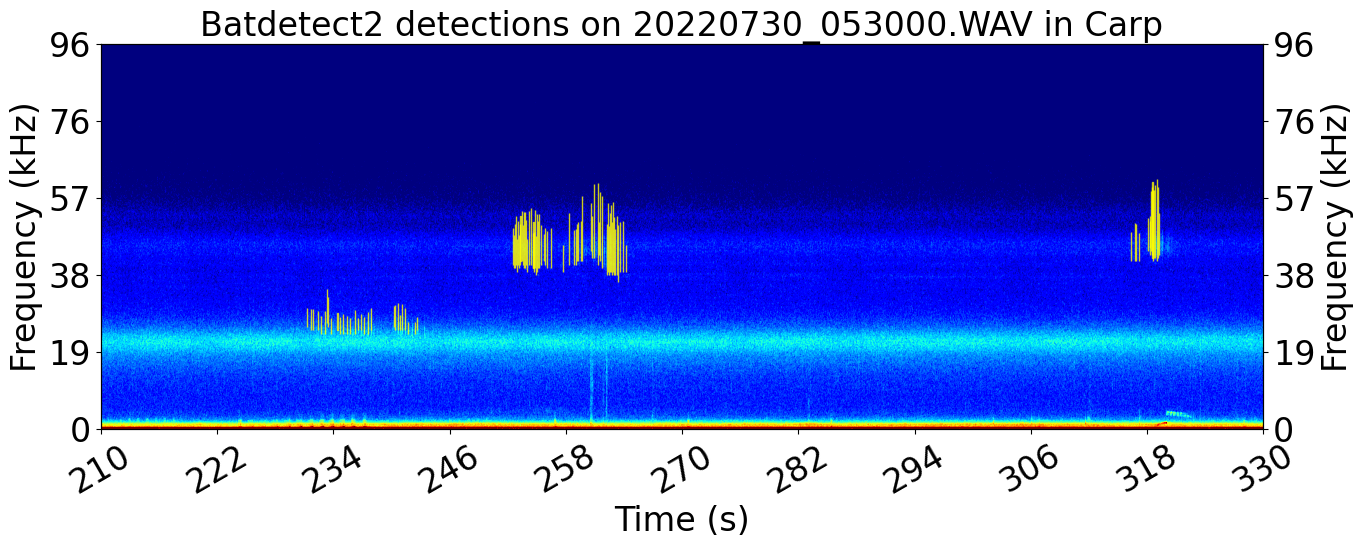

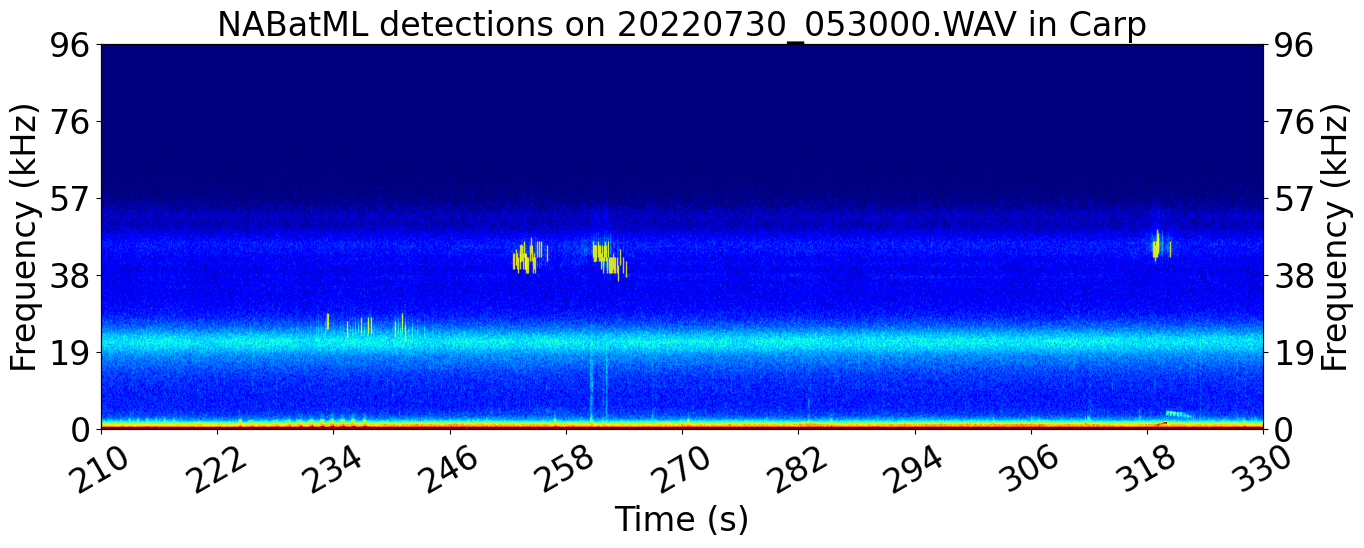

In [20]:
spec_features['plot_title'] = f"Batdetect2 detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, batdetect2_df)
spec_features['plot_title'] = f"NABatML detections on {audio_features['file_path'].name} in {site}"
plot_dets_over_audio(audio_features, spec_features, bd2_nabat_df)

In [21]:
def return_confusion_matrix_from_comparing_two_detectors(human_df, machine_df):
    false_positives = 0 ## machine made detection that human did not make
    true_positives = 0  ## machine made detection that human made
    true_negatives = 0  ## machine did not make detection that human also did not make
    false_negatives = 0 ## machine did not make detection that human made
    human_ind = 0
    machine_ind = 0

    while (human_ind < len(human_df))&(machine_ind < len(machine_df)):
        # print(human_ind, machine_ind)
        human_det = human_df.iloc[human_ind]

        machine_det = machine_df.iloc[machine_ind]

        machine_det_start_in_human_det_bounds = ((machine_det['start_time']>=human_det['start_time'])&(machine_det['start_time']<=human_det['end_time']))
        machine_det_end_in_human_det_bounds = ((machine_det['end_time']>=human_det['start_time'])&(machine_det['end_time']<=human_det['end_time']))
        human_det_start_in_machine_det_bounds = ((human_det['start_time']>=machine_det['start_time'])&(human_det['start_time']<=machine_det['end_time']))
        human_det_end_in_machine_det_bounds = ((human_det['end_time']>=machine_det['start_time'])&(human_det['end_time']<=machine_det['end_time']))

        machine_det_in_human_bounds = machine_det_start_in_human_det_bounds|machine_det_end_in_human_det_bounds
        human_det_in_machine_bounds = human_det_start_in_machine_det_bounds|human_det_end_in_machine_det_bounds

        # if human_ind>=295:
        #     print('bug')
        #     print(human_det['start_time'], human_det['end_time'])
        #     print(machine_det['start_time'], machine_det['end_time'])
        if (machine_det_in_human_bounds|human_det_in_machine_bounds):
            true_positives += 1
            machine_ind+=1
            human_ind+=1
        else:
            if (machine_det['end_time']<human_det['start_time']):
                false_positives += 1
                machine_ind+=1
            elif (machine_det['start_time']>human_det['end_time']):
                false_negatives += 1
                human_ind+=1
            else:
                true_negatives += 1

    if (machine_ind<len(machine_df)):
        false_positives += (len(machine_df) - (machine_ind))
    if (human_ind<len(human_df)):
        false_negatives += (len(human_df) - (human_ind))

    assert((true_positives+false_negatives)==len(human_df))
    assert((false_positives+true_positives)==len(machine_df))

    return {'true_positives':true_positives, 'false_positives':false_positives, 'false_negatives':false_negatives, 'true_negatives':true_negatives}

## Following the confusion matrix structure shown below

![image](example_confusion_matrix.png)

In [22]:
return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, bd2_nabat_df)

{'true_positives': 214,
 'false_positives': 5,
 'false_negatives': 458,
 'true_negatives': 0}

In [23]:
return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, bd2_kaleido_df)

{'true_positives': 82,
 'false_positives': 0,
 'false_negatives': 590,
 'true_negatives': 0}

In [24]:
return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, batdetect2_df)

{'true_positives': 344,
 'false_positives': 0,
 'false_negatives': 328,
 'true_negatives': 0}

In [25]:
return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, batdetect2_df_mod)

{'true_positives': 508,
 'false_positives': 29,
 'false_negatives': 164,
 'true_negatives': 0}

In [26]:
file_sites = {'20220730_053000':'Carp',
 '20220727_083000':'Foliage',
 '20220829_090000':'Foliage',
 '20220826_070000':'Central'}

file_keys = list(file_sites.keys())
file_keys

['20220730_053000', '20220727_083000', '20220829_090000', '20220826_070000']

In [27]:
kaleido_cf_matrices = {'true_positives':0, 'false_positives':0, 'false_negatives':0, 'true_negatives':0}
batdetect2_cf_matrices = {'true_positives':0, 'false_positives':0, 'false_negatives':0, 'true_negatives':0}
batdetect2_mod_cf_matrices = {'true_positives':0, 'false_positives':0, 'false_negatives':0, 'true_negatives':0}
nabat_cf_matrices = {'true_positives':0, 'false_positives':0, 'false_negatives':0, 'true_negatives':0}

for file_key in file_keys:
    wav_filename = file_key
    site = file_sites[file_key]
    print(wav_filename, site)

    kaleido_df = pd.read_csv(f'../../Documents/{wav_filename}/output/cluster.csv')
    bd2_kaleido_df = convert_kaleidoscopedf_to_bd2df(kaleido_df)

    raventxt_human_df = pd.read_csv(f'../../Documents/Research/mila_files/mila-human-wav-txt/{wav_filename}.txt', sep='\t')
    bd2_human_df = convert_raventxtdf_to_bd2df(raventxt_human_df)
    bd2_human_df.reset_index(inplace=True, drop=True)

    batdetect2_df = pd.read_csv(f'../../duty-cycle-investigation/data/raw/{site}/bd2__{site}_{wav_filename}.csv', sep=',')

    nabat_df = pd.read_csv(f'../../nabat-ml-master/classify/nb__{wav_filename}.csv', index_col=0)
    bd2_nabat_df = convert_nabatdf_to_bd2df(nabat_df)

    print('Kaleidoscope confusion matrix')
    file_kaleido_cf = return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, bd2_kaleido_df)
    print(file_kaleido_cf)
    kaleido_cf_matrices['true_positives'] += file_kaleido_cf['true_positives']
    kaleido_cf_matrices['false_positives'] += file_kaleido_cf['false_positives']
    kaleido_cf_matrices['false_negatives'] += file_kaleido_cf['false_negatives']
    kaleido_cf_matrices['true_negatives'] += file_kaleido_cf['true_negatives']

    print('Batdetect2 confusion matrix')
    file_batdetect2_cf = return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, batdetect2_df)
    print(file_batdetect2_cf)
    batdetect2_cf_matrices['true_positives'] += file_batdetect2_cf['true_positives']
    batdetect2_cf_matrices['false_positives'] += file_batdetect2_cf['false_positives']
    batdetect2_cf_matrices['false_negatives'] += file_batdetect2_cf['false_negatives']
    batdetect2_cf_matrices['true_negatives'] += file_batdetect2_cf['true_negatives']

    print('Batdetect2-mod confusion matrix')
    file_batdetect2_mod_cf = return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, batdetect2_df_mod)
    print(file_batdetect2_cf)
    batdetect2_mod_cf_matrices['true_positives'] += file_batdetect2_mod_cf['true_positives']
    batdetect2_mod_cf_matrices['false_positives'] += file_batdetect2_mod_cf['false_positives']
    batdetect2_mod_cf_matrices['false_negatives'] += file_batdetect2_mod_cf['false_negatives']
    batdetect2_mod_cf_matrices['true_negatives'] += file_batdetect2_mod_cf['true_negatives']

    print('NABatML confusion matrix')
    file_nabat_cf = return_confusion_matrix_from_comparing_two_detectors(bd2_human_df, bd2_nabat_df)
    print(file_nabat_cf)
    nabat_cf_matrices['true_positives'] += file_nabat_cf['true_positives']
    nabat_cf_matrices['false_positives'] += file_nabat_cf['false_positives']
    nabat_cf_matrices['false_negatives'] += file_nabat_cf['false_negatives']
    nabat_cf_matrices['true_negatives'] += file_nabat_cf['true_negatives']

20220730_053000 Carp
Kaleidoscope confusion matrix
{'true_positives': 82, 'false_positives': 0, 'false_negatives': 590, 'true_negatives': 0}
Batdetect2 confusion matrix
{'true_positives': 344, 'false_positives': 0, 'false_negatives': 328, 'true_negatives': 0}
Batdetect2-mod confusion matrix
{'true_positives': 344, 'false_positives': 0, 'false_negatives': 328, 'true_negatives': 0}
NABatML confusion matrix
{'true_positives': 214, 'false_positives': 5, 'false_negatives': 458, 'true_negatives': 0}
20220727_083000 Foliage
Kaleidoscope confusion matrix
{'true_positives': 1, 'false_positives': 0, 'false_negatives': 122, 'true_negatives': 0}
Batdetect2 confusion matrix
{'true_positives': 22, 'false_positives': 1, 'false_negatives': 101, 'true_negatives': 0}
Batdetect2-mod confusion matrix
{'true_positives': 22, 'false_positives': 1, 'false_negatives': 101, 'true_negatives': 0}
NABatML confusion matrix
{'true_positives': 0, 'false_positives': 3, 'false_negatives': 123, 'true_negatives': 0}
2022

In [28]:
kaleido_cf_matrices

{'true_positives': 645,
 'false_positives': 17,
 'false_negatives': 2918,
 'true_negatives': 0}

In [29]:
batdetect2_cf_matrices

{'true_positives': 2001,
 'false_positives': 1,
 'false_negatives': 1562,
 'true_negatives': 0}

In [30]:
batdetect2_mod_cf_matrices

{'true_positives': 531,
 'false_positives': 1617,
 'false_negatives': 3032,
 'true_negatives': 0}

In [31]:
nabat_cf_matrices

{'true_positives': 1405,
 'false_positives': 126,
 'false_negatives': 2158,
 'true_negatives': 0}